# COCO Data Generator for Semantic Segmentation
_Viraf Patrawala (March, 2020)_

The [**COCO (Common Objects in Context)**](http://cocodataset.org/#home "COCO Homepage") dataset consists of [80 output classes](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda). This labelled dataset can be used for image classification, segmentation and captioning problems.
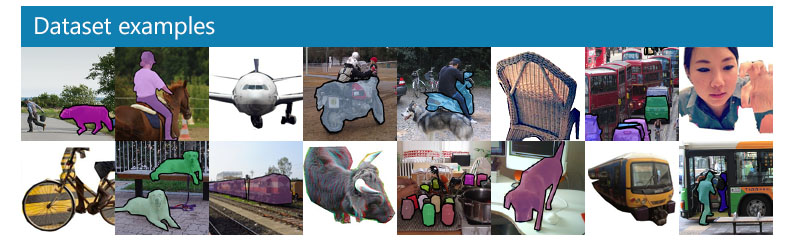

Here we first have a quick introduction to how pycoco works and then, we create a data generator object using [pycoco](https://pypi.org/project/pycoco/#description) and [tensorflow keras](https://www.tensorflow.org/guide/keras) to ease training models on the COCO dataset.


### Goals
1) Get subsets of the COCO dataset as per requirement  
2) Generate masks from the given COCO annotations  
3) Add image augmentations  
4) Create a data generator object to ease training models


___

You can have a look at the [Pycoco demo notebook](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) first to get a better understanding of the following code.

## STEP 1: Download and Arrange the data

[Download](http://cocodataset.org/#download "Download COCO") the following files on to your PC. 

**2017 train images, 2017 val images, 2017 Train/Val annotations**

(Since the files are quite large, they might take some time, so be patient.)

Some simple re-arrangement and re-naming of folders required as below. The file structure for the following code is:
```
Project Folder
└───this code notebook
│
└───COCOdataset2017   
    └───images
    │   └───train
    │   │    │   000000000009.jpg
    │   │    │   000000000025.jpg
    │   │    │   ...
    │   └───val   
    │        │   000000000139.jpg
    │        │   000000000285.jpg
    │        │   ...
    └───annotations
        │   instances_train.json
        │   instances_val.json
```

## STEP 2: Install and Import Required Libraries

Have a look at the import statements below. Install any module you might not already have. 

In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from itertools import combinations
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.util import montage

## STEP 3: PyCoco Review

In [2]:
dataDir='./COCOdataset2017'
dataType='val'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [3]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

12 COCO supercategories: 
kitchen outdoor person accessory electronic food indoor animal sports vehicle furniture appliance




#### Class Filtering
Many times, you might not want to use all the [80 output classes](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda) provided by COCO. This method is used for filtering out images from the dataset of classes that you want.


In [4]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['laptop', 'tv', 'cell phone']);
imgIds = coco.getImgIds(catIds=catIds);
# imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print("Number of images containing all required classes:", len(imgIds))

Number of images containing all required classes: 11


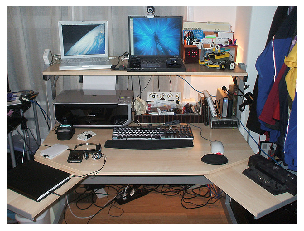

In [5]:
# load and display image
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
# use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

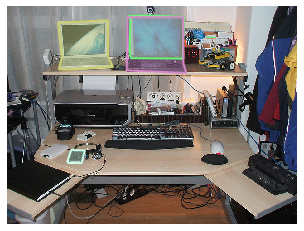

In [6]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

## STEP 4: A Few Concepts

#### Binary Masking

In general, your output mask will _N_ possible pixel values for N output classes. However, binary masking implies that the output mask will have **Only 2 pixel values**, i.e., 0 and 1. 0 will represent the background and 1 will represent the objects.

If donot wish for a binary mask and want the ordinary masks instead, you can uncomment the commented line in the code below, and comment the next line.


array([0., 1.])

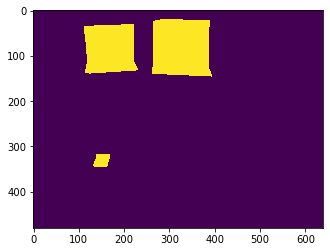

In [8]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
#     mask = np.maximum(coco.annToMask(anns[i])*anns[i]['category_id'], mask)  ##***Uncomment for normal mask
    mask = np.maximum(coco.annToMask(anns[i]), mask)                           ##***Comment for normal mask
plt.imshow(mask)
np.unique(mask)

#### All Possible Combinations

When we filter the dataset with classes, the pycoco tool assumes that you want *all the classes in the image*, which is why it returns images with only ALL your required classes, not one or two or other combinations.

Thus, this piece of code will ensure that all possible combinations for the given class lists are obtained in the resultant dataset.

See how above, we had received only 11 images, but now there are 727 images!

In [9]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['cell phone','tv', 'laptop']
images = []
if classes!=None:
    for numberClasses in range (len(classes)):
        class_subset = [";;;".join(map(str, comb)) for comb in combinations(classes, numberClasses+1)]
        for numberSubsetClasses in range(len(class_subset)):
            classList = class_subset[numberSubsetClasses].split(';;;')       
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=classList)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)

dataset_size = len(images)

dataset_size

727

## STEP 5: Combine

Now we mix all these concepts to create our data generator.

In [10]:
def removeGreyscaleImages(images, img_folder):
    i=0
    while(i<len(images)):
        img = io.imread(img_folder + '/' + images[i]['file_name'])
        try:
            img.shape[2]==3
            i+=1
        except:
            images.pop(i)   
    print('greyscale images removed')
    return images

def filterDataset(folder, classes=None,  mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        for numberClasses in range(len(classes)):
            class_subset = [";;;".join(map(str, comb)) for comb in combinations(classes, numberClasses+1)]
            for numberSubsetClasses in range(len(class_subset)):
                classList = class_subset[numberSubsetClasses].split(';;;')       
                # get all images containing given categories
                catIds = coco.getCatIds(catNms=classList)
                imgIds = coco.getImgIds(catIds=catIds)
                images += coco.loadImgs(imgIds)
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
        
    
    img_folder = '{}/images/{}'.format(folder, mode)
    
    # Filter out images having only two channels (greyscale)
    images = removeGreyscaleImages(images, img_folder)    
        
    random.shuffle(images)
    dataset_size = len(images)
    
    return images, dataset_size, coco, catIds

In [11]:
folder = './COCOdataset2017'
classes = ['laptop', 'tv', 'cell phone']

images, dataset_size, coco, catIds = filterDataset(folder, classes,  mode='val')

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
greyscale images removed


In [12]:
def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    return train_img


def getMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, coco, folder, dataset_size, catIds, 
                      input_image_size = (128,128), batch_size=4, mode='train'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    c = 0
    
    while (True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ###### Image ######
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ###### Mask ######
            train_mask = getMask(imageObj, coco, catIds, input_image_size)
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

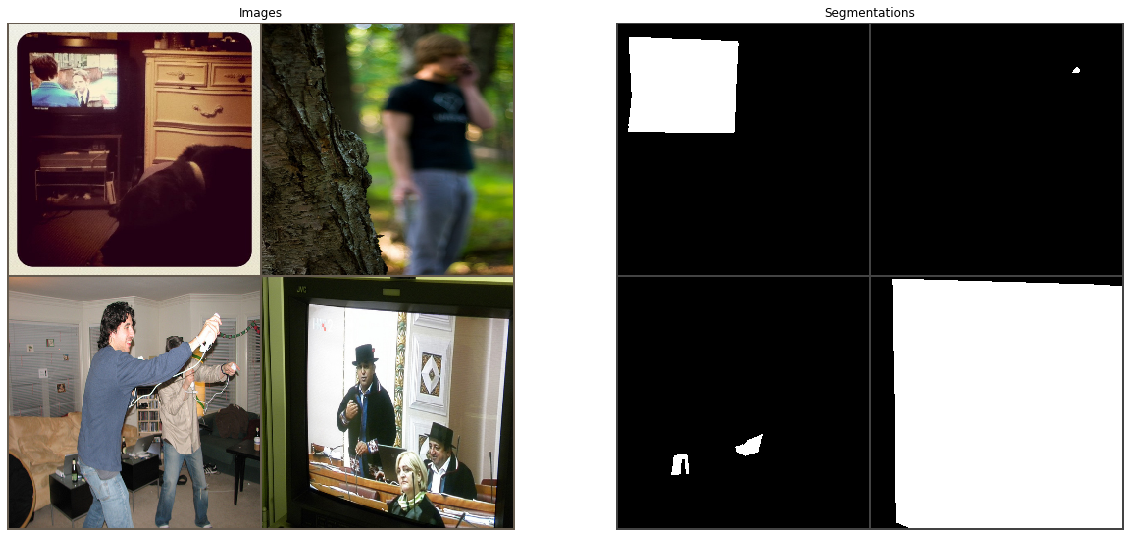

In [13]:
batch_size = 4
input_image_size = (256,256)

val_gen = dataGeneratorCoco(images, coco, folder, dataset_size, catIds, input_image_size, batch_size, mode='val')

############# Visualize #############
train_img, train_mask = next(val_gen)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i], padding_width = 2) for i in range(x.shape[3])], -1)
batch_rgb = montage_rgb(train_img)
batch_seg = montage(train_mask[:, :, :, 0], padding_width = 2)
ax1.imshow(batch_rgb); ax1.axis('off')
_ = ax1.set_title('Images')
ax2.imshow(batch_seg,cmap='gray'); ax2.axis('off')
_ = ax2.set_title('Segmentations')

## STEP 6: Augmentations

With the above 5 steps, our COCO data generator is already ready! But, if you wish to add data augmentations to your images to increase potential dataset size, follow the code below!

In [14]:
def augmentationsGenerator(in_gen, augGeneratorArgs, seed = None):
    
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    mask_gen = ImageDataGenerator(**augGeneratorArgs)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(in_y, 
                             batch_size = in_y.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

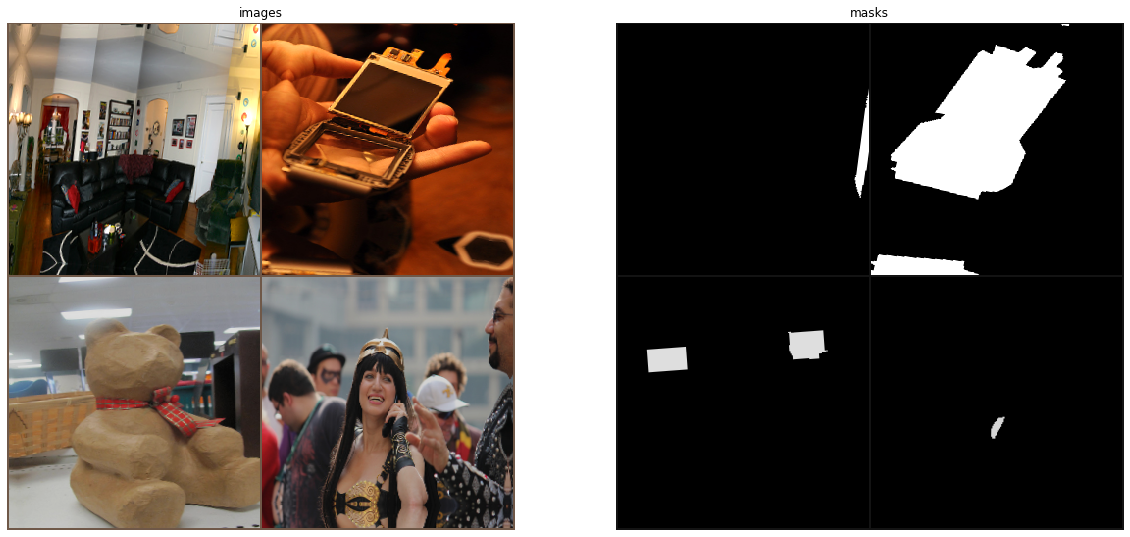

In [15]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 15, 
                        width_shift_range = 0.1, 
                        height_shift_range = 0.1, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [0.9, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

cur_gen = augmentationsGenerator(val_gen, augGeneratorArgs)


############# Visualize #############
t_x, t_y = next(cur_gen)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray'); ax1.axis('off')
_ = ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0], padding_width = 2), cmap='gray'); ax2.axis('off')
_ = ax2.set_title('masks')